<a href="https://colab.research.google.com/github/ross-hugo/Artwork-GAN/blob/main/Discriminator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ross-hugo/Artwork-GAN/

fatal: destination path 'Artwork-GAN' already exists and is not an empty directory.


In [2]:
cd Artwork-GAN/

/content/Artwork-GAN


In [3]:
from keras.preprocessing import image_dataset_from_directory
dir = "images/"
train_ds = image_dataset_from_directory(dir,
  validation_split=0.2, subset="training",
  seed=123,
  labels="inferred",label_mode="int"
  ,image_size=(128, 128), color_mode= "rgb")
val_ds = image_dataset_from_directory(dir,
  validation_split=0.2, subset="validation",
  seed=123,
  labels="inferred",label_mode="int"
  ,image_size=(128, 128), color_mode= "rgb")

Found 8118 files belonging to 49 classes.
Using 6495 files for training.
Found 8118 files belonging to 49 classes.
Using 1623 files for validation.


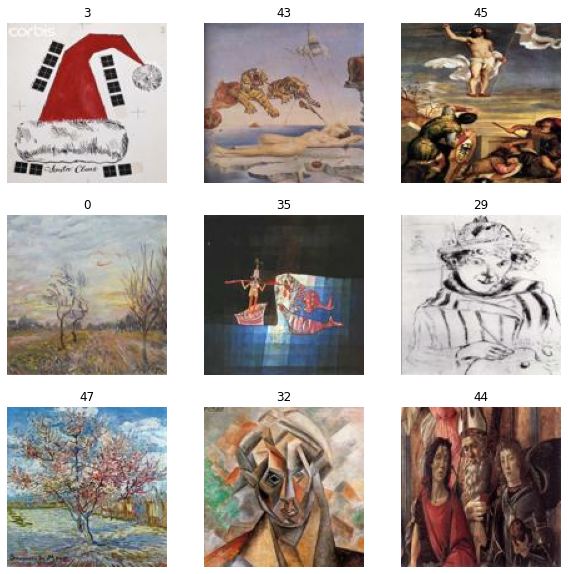

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(int(labels[i]))
      plt.axis("off")

In [5]:
#discriminator.py
from keras.datasets import mnist #for testing on some data
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, GlobalAveragePooling1D

from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers.convolutional import UpSampling2D, Conv2D
import matplotlib.pyplot as plt
import sys
import numpy as np
from scipy import ndimage


#losses: rotation loss & hinge loss (for the true versus fake prediction)
#penalties (such as the gradient penalty)
#normalization techniques: self-modulated batch normalization which doesnt require labels
#neural architecture: ResNet
#evaluation metrics: FID score
#ResNet contains 6 blocks
#I'm assuming that we will have a GAN class and inside that class we'll have the discriminator and generator functions

class Discriminator():
  
  # def __init__(self, flags, data):
  def __init__(self):
    self.resnet = None
    self.lrelu = None
    self.sn  = None
    # self.input_shape = (28, 28, 1) 
    self.img_shape = (128, 128, 1)
    self.model = None

  #discriminator outputs likelihood of image being real
  # def discriminator(self, resnet):
  def define_model(self):  
     #as per paper batch normalization is omitted in the discriminator
     #leakyRelu / conv / leakyrelu / conv
     #4 resblocks --> relu, global sum pooling, dense 

      model = Sequential()
      
      #block1
      # model.add(LeakyReLU(alpha=0.2))
      model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))


      #block2
      model.add(LeakyReLU(alpha=0.2))
      model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
      
      #block3
      model.add(LeakyReLU(alpha=0.2))
      model.add(Conv2D(128, kernel_size=3, strides=2,  padding="same"))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))

      #block4
      model.add(LeakyReLU(alpha=0.2))
      model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))

      #add ReLU layer
      model.add(LeakyReLU(alpha=0.2))

      #add global sum pooling layer (is sum pooling the same as average pooling?) - also what parameters to be added here?
      # model.add(GlobalAveragePooling1D(self.input_shape)) # (batch_size, steps, features)
 
      model.add(Flatten())

      # model.summary()

      # img = Input(shape=self.img_shape)

      # features = model(img)
      # valid = Dense(1, activation="sigmoid")(features)
      # label = Dense(self.num_classes+1, activation="softmax")(features)
      
      #valid = model(img)
      # return Model(img, [valid, label]) #return img and validity
      #return Model(img, valid)

      # from https://github.com/vandit15/Self-Supervised-Gans-Pytorch/blob/01408fcce3e6cf4795d90c0f9d27e6906d5b59f3/main.py
      lr = 1e-4
      betas = (.9, .99)
      opt = Adam(learning_rate=lr, beta_1= betas[0], beta_2=betas[1])
      model.compile(loss="binary_crossentropy", optimizer=opt)
      
      self.model = model
      return self.model

  def train(self, epochs, batch_size=128, save_interval=500):
    # #load real images
    # (X_train,_), (Y_train,_) = mnist.load_data() #we're not gonna use Y_train but it bothers me to leave it out

    # #normalize data (-1 to 1) 
    # #if you want to do 0 to 1 change 127.5 to 255
    # # X_train = (X_train.astype(np.float32)-127.5) /127.5
    # # X_train = X_train.astype(np.float32)/255
    # #add dimension, if input to gen and discr has shape 28x28x1, then 3 dimensions
    # X_train = np.expand_dims(X_train, axis=3)
    # half_size = int(batch_size/2)

    # for epoch in range(epochs)
    #     idx = np.random.randint(0, X_train.shape[0], half_size)
    #     imgs = X_train[idx]

    #     #half batch number of vectors, each of size 100
    #     noise = np.random.normal(0,1,(half_size, 100)) #for generator
    #     #generate half batch of fake images
    #     gen_imgs = generator.predict(noise)

    #     ########################
    #     #Training Discriminator#
    #     ########################
    #     #train discriminator on real images
    #     d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    #     #train discriminator on fake images
    #     d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_size,1)))
    #     #averaged loss
    #     d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #add and divide by 2


    #     ########################
    #     ###Training Generator###
    #     ########################
    #     #generating fake images
    #     noise = np.random.normal(0,1,(batch_size, 100)) 
    #     #telling discriminator the image is real
    #     valid_y = np.array([1] * batch_size)

    #     g_loss = combined.train_on_batch(noise, valid_y)
      pass

  

  #function to predict whether an image is real or fake 
  def predict_real_fake():
    pass

  #function to predict what rotation angle we're working with
  def rotation_angle():
    pass


In [6]:
#discriminator would use a resnet architecture
#how to build a resnet as a discriminator
#what are the parameters that they've used for the ResNet?
#will start here by building the resnet
#--------> I'll continue working in the discriminator.py file

###anna's sudo code pls ignore
#for epoch in range(num_epoch):
   #train model
   #for each id in ... the dataset
      #first "optimize"
      #image = "image"
      #representation = model(image)
      # #calculate loss
      # optimize 

from keras.datasets import mnist 
# from discriminator import Discriminator
from keras.utils import to_categorical

D = Discriminator()
model = D.define_model()



def rotate_img(img, rot):
  if rot == 0:  # 0 degrees rotation
    return img
  elif rot == 90:
    return np.rot90(img,k=1, axes=(1,2))
  elif rot == 180:
    return np.rot90(img,k=2, axes=(1,2))
  elif rot == 270:
    return np.rot90(img,k=3, axes=(1,2))
  else:
    raise ValueError("rotation not valid")
  # elif rot == 90:  # 90 degrees rotation
  #     return np.flipud(np.transpose(img, (1, 0, 2)))
  # elif rot == 180:  # 90 degrees rotation
  #     return np.fliplr(np.flipud(img))
  # elif rot == 270:  # 270 degrees rotation / or -90
  #     return np.transpose(np.flipud(img), (1, 0, 2))
  # elif rot == 120:
  #     return ndimage.rotate(img, 120, reshape=False)
  # elif rot == 240:
  #     return ndimage.rotate(img, 240, reshape=False)
  # else:
  #     raise ValueError('rotation error')

def train_epoch(X, y ):
  assert len(X) == len(y)
  for i ,data in enumerate(X):
    # Get generated data from generator

    x = data
    x_90 = rotate_img(x, 90)
    x_180 = rotate_img(x, 180)
    x_270 = rotate_img(x, 270)
    new_image = np.vstack(x, x_90, x_180, x_270)

# train_data_gen = get_data_generator(X_train, y_train)
# test_data_gen = get_data_generator(X_test, y_test)

# print(model.evaluate_generator(train_data_gen))



